## Main code for cavity state-to-state transfer pulse optimization
test: $\ket{0}$ to $\ket{\alpha}$    

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
from qutip import Qobj, identity, sigmax, sigmaz, tensor
import qutip as qt
import random
import qutip.logging_utils as logging
logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
log_level = logging.INFO
#QuTiP control modules
import qutip.control.pulseoptim as cpo
import qutip.control.pulsegen as pulsegen
from qutip import *

### helper functions ###
def time (n_ts,evo_time):
    return np.linspace(0,evo_time,n_ts)

### Defining the physics
Drift Hamiltonian:  
From phD thesis (2.13)  
(before frame rotation)
$$
H_0 = \omega_q a^\dagger a + \frac{\omega_z}{2} \sigma_z
$$
$H_0$ can be rotated away,
$$
H_{d1} = \frac{\chi}{2} a^\dagger a \sigma_z
$$
It can be shown that it's equivalent to:  
$$
\begin{align*}
    H_{d2} &= g\left( \hat{\sigma}_+ \hat{\sigma}_- + \hat{a}^{\dagger}\hat{a}\hat{\sigma}_z \right) \\
    &= g \left( \frac{1}{2}(1+\hat{\sigma}_x) + \hat{n}\hat{\sigma}_z\right)
\end{align*}
$$  
where, $g$ is the cavity-qubit coupling strength

Contrl Hamiltonian: 
$$
H_{c1} = \epsilon_c(t) \hat{a} + \epsilon_T(t) \hat{\sigma}_- + h.c.
$$

where, 
- $\epsilon_c(t)$ is the contorl signal to cavity
- $\epsilon_T(t)$ is the control signal to ancilliary qubit

with $\hat{\sigma}_- = \frac{1}{2} \hat{\sigma}_x - \frac{i}{2}\hat{\sigma}_y$, 
$$
H_{c2} = \epsilon_c(t) \hat{a} + \epsilon_T(t) (\frac{1}{2} \hat{\sigma}_x - \frac{i}{2}\hat{\sigma}_y) + h.c.
$$
Assuming that the control signals $\epsilon_c(t), \epsilon_T(t)$ are real, and ignoring scalar constants, we have 
$$
H_{c3} = \epsilon_c(t) (\hat{a}+\hat{a}^{\dagger}) + \epsilon_T(t) \hat{\sigma}_x
$$

If NOT assuming that the control signals are real, and ignoring the coupling term, we have 

\begin{align}
H_{c4} 
&= \epsilon_c(t) \hat{a}^{\dagger} + \epsilon_c^*(t) \hat{a} \\
&= \epsilon_{c1}(t) (\hat{a}^{\dagger}+\hat{a}) + i\epsilon_{c2}(t) (\hat{a}^{\dagger}-\hat{a}) \quad \text{where, }\epsilon_{c1}(t),\epsilon_{c2}(t) \in \mathbb{R}
\end{align}

$\epsilon(t) = \epsilon_{c1}(t)+ i\epsilon_{c2}(t)$, $\epsilon(t)$ is the AC control signal.


Initial and target states: 
$$
\begin{align*}
    \ket{\psi_{\text{initial}}} &= \ket{\alpha} \\
    \ket{\psi_{\text{final}}} &= \ket{\alpha} + \ket{-\alpha}
\end{align*}
$$

For testing the code, consider
$$
\begin{align*}
    \ket{\psi_{\text{initial}}} &= \ket{0} \\
    \ket{\psi_{\text{final}}} &= \ket{\alpha}
\end{align*}
$$


In [3]:
g = 10**(-3) # cavity qubit coupling strength
N = 5 # Fock space truncation

#### actual goal ####
# H_0 + H_d1
# H_d = tensor(qt.num(N), identity(2)) + tensor(identity(N), sigmaz()) + tensor(qt.num(N), sigmaz())


# H_d2 = g*((tensor(identity(N), identity(2)) + tensor(identity(N), sigmax()))/2 + 
#          tensor(qt.num(N), sigmaz())) # drift Hamiltonian (in composite Hilbert space)

# H_c = [tensor(qt.destroy(N)+qt.create(N), identity(2)), 
#        tensor(identity(N), qt.sigmax())] # two control Hamiltonians (in composite Hilbert space)

#### testing ####
# set chi to 0, don't need this for testing state-to-state transfer
H_dt = tensor(qt.num(N), identity(2)) + tensor(identity(N), sigmaz())
H_c4 = [tensor(qt.destroy(N) + qt.create(N), identity(2)),
       tensor(1j*(qt.destroy(N) - qt.create(N)), identity(2))]


#### set Hamiltonian ####
H_d = H_dt
H_c = H_c4
n_ctrls = len(H_c)

H_labels = [r'$u_c1$',
            r'$u_c2$'] # two control Hamiltonian labels

#### initial and target states ####
# coherent state complex amplitude
# alpha = np.sqrt(2) 
alpha = 0.5
# try root 2
cavity_init_state = qt.coherent(N, alpha)
cavity_target_state = (qt.coherent(N, alpha) + qt.coherent(N, -alpha)).unit()

#### testing ####
# vacuum state to coherent state 
cavity_init_state_testing = qt.coherent(N, 0)
cavity_target_state_testing = qt.coherent(N, alpha)

qubit_state = Qobj([[1], [0]])

psi_0 = tensor(cavity_init_state_testing, qubit_state)
psi_targ = tensor(cavity_target_state_testing, qubit_state)

### Defining the time evolution parameters

In [4]:
# Number of time slots
# n_ts = 3_000
n_ts = 100
# Time allowed for the evolution 
evo_time = 1

### Set the conditions which will cause the pulse optimisation to terminate

At each iteration the fidelity of the evolution is tested by comparaing the calculated evolution U(T) with the target U_targ. For unitary systems such as this one this is typically:
f = normalise(overlap(U(T), U_targ)). The maximum fidelity (for a unitary system) calculated this way would be 1, and hence the error is calculated as fid_err = 1 - fidelity. As such the optimisation is considered completed when the fid_err falls below such a target value.

In some cases the optimisation either gets stuck in some local minima, or the fid_err_targ is just not achievable, therefore some limits are set to the time/effort allowed to find a solution.

The algorithm uses the CRAB algorithm to determine optimized coefficients that lead to a minimal fidelity error. The underlying optimization procedure is set to be the Nelder-Mead downhill simplex. Therefore, when all vertices shrink together, the algorithm will terminate.

In [5]:
# Fidelity error target
fid_err_targ = 1e-4
# Maximum iterations for the optisation algorithm
max_iter = 100_000
# Maximum (elapsed) time allowed in seconds
max_wall_time = 10_000

### Set the guess pulse type

The control amplitudes must be set to some initial values. Typically these are just random values for each control in each timeslot. These do however result in erratic optimised pulses. For this example, a solution will be found for any initial pulse, and so it can be interesting to look at the other initial pulse alternatives.

In [6]:
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|DEF
p_type = 'LIN'

### Give an extension for output files

In [7]:
# Set to None to suppress output files
code_name = 'coherent_to_cat_state'
f_ext = "{}_n_ts{}_evo_time{}_ptype{}_alpha{}_N{}_fid_err_targ{}_max_iter{}_max_wall_time{}.txt".format(code_name, n_ts, evo_time, p_type, alpha, N, fid_err_targ, max_iter, max_wall_time)
# f_ext = None

### Run the optimisation (Auto)

In this step, the actual optimization is performed. At each iteration the Nelder-Mead algorithm calculates a new set of coefficients that improves the currently worst set among all set of coefficients. For details see [1,2] and a textbook about static search methods. The algorithm continues until one of the termination conditions defined above has been reached. If undesired results are achieved, rerun the algorithm and/or try to change the number of coefficients to be optimized for, as this is a very crucial parameter.

In [8]:
######## CRAB ########
# result = cpo.opt_pulse_crab_unitary(H_d, H_c, psi_0, psi_targ, n_ts, evo_time, 
#                 fid_err_targ=fid_err_targ, 
#                 max_iter=max_iter, max_wall_time=max_wall_time, 
#                 init_coeff_scaling=5.0, num_coeffs=10, 
#                 method_params={'xtol':1e-3},
#                 guess_pulse_type=p_type, guess_pulse_action='ADD',
#                 out_file_ext=f_ext,
#                 log_level=log_level, gen_stats=True)

# figure out how to print current fidelity at each optimization itteration
# should move up quickly in 20 iterations
# to see that it's climbing rapidly in the start

######## GRAPE ########
result = cpo.optimize_pulse_unitary(H_d, H_c, psi_0, psi_targ, n_ts, evo_time, 
                fid_err_targ=fid_err_targ, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                method_params={'xtol':1e-3},
                init_pulse_type=p_type,
                out_file_ext=f_ext,
                log_level=log_level, gen_stats=True)

INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[5, 2], [5, 2]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  3.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  4.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  2.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  5.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 

### Run optimization (semi-auto, CRAB)
refer to sample code: 
/Users/JohnnyLin/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Desktop/NUS/Y4S1DT/FYP-DT/FYP-sample_code/control-pulseoptim-CRAB-QFT.ipynb

In [9]:
# Create optimizer object and optimize
# from source code: 
# create_pulse_optimizer(
#         drift, ctrls, initial, target,
#         num_tslots=None, evo_time=None, tau=None,
#         amp_lbound=None, amp_ubound=None,
#         fid_err_targ=1e-10, min_grad=1e-10,
#         max_iter=500, max_wall_time=180,
#         alg='GRAPE', alg_params=None,
#         optim_params=None, optim_method='DEF', method_params=None,
#         optim_alg=None, max_metric_corr=None, accuracy_factor=None,
#         dyn_type='GEN_MAT', dyn_params=None,
#         prop_type='DEF', prop_params=None,
#         fid_type='DEF', fid_params=None,
#         phase_option=None, fid_err_scale_factor=None,
#         tslot_type='DEF', tslot_params=None,
#         amp_update_mode=None,
#         init_pulse_type='DEF', init_pulse_params=None,
#         pulse_scaling=1.0, pulse_offset=0.0,
#         ramping_pulse_type=None, ramping_pulse_params=None,
#         log_level=logging.NOTSET, gen_stats=False)
optim = cpo.create_pulse_optimizer(
                H_d, H_c, psi_0, psi_targ, n_ts, evo_time, 
                fid_err_targ=fid_err_targ, 
                max_iter=max_iter, max_wall_time=max_wall_time,
                # alg='CRAB', 
                # alg='CRAB', 
                # init_pulse_type='SQUARE',
                # init_pulse_params={'scaling':1.0,'num_waves':1},
                # alg_params={},
                dyn_type='UNIT', 
                prop_type='DIAG', 
                fid_type='UNIT', fid_params={'phase_option':'PSU'}, 
                log_level=log_level, gen_stats=True)


### Configure the pulses for each of the controls

In [10]:
# dyn = optim.dynamics

# # Control 1
# crab_pgen = optim.pulse_generator
# guess_pgen = pulsegen.create_pulse_gen('SQUARE', dyn=dyn, 
#                                            pulse_params={'scaling':3.0,'num_waves':1})
# crab_pgen.guess_pulse = guess_pgen.gen_pulse()
# crab_pgen.scaling = 0.0
# # Add some higher frequency components
# crab_pgen.num_coeffs = 100

# # Control 2
# crab_pgen = optim.pulse_generator
# guess_pgen = pulsegen.create_pulse_gen('SQUARE', dyn=dyn, 
#                                            pulse_params={'scaling':3.0,'num_waves':1})
# crab_pgen.guess_pulse = guess_pgen.gen_pulse()
# crab_pgen.scaling = 0.0
# # Add some higher frequency components
# crab_pgen.num_coeffs = 100


# init_amps = np.zeros([n_ts, n_ctrls])
# # for j in range(dyn.num_ctrls):
# #     pgen = optim.pulse_generator[j]
# #     pgen.init_pulse()
# #     init_amps[:, j] = pgen.gen_pulse()

# dyn.initialize_controls(init_amps)

In [11]:
# ## test generating and plotting pulses ##
# test_pulse_gen = pulsegen.create_pulse_gen('SQUARE', dyn=dyn, pulse_params={'scaling':1.0})
# # set periodic parameters
# test_pulse_gen.num_waves = 2

# test_pulse = test_pulse_gen.gen_pulse()
# fig1 = plt.figure()
# ax1 = fig1.add_subplot(3, 1, 1)
# ax1.set_title("amps")
# ax1.set_xlabel("Time")
# ax1.set_ylabel("amplitude")
# time_array = time(n_ts, evo_time)
# pulse = test_pulse
# ax1.step(np.append(time_array,time_array[-1] + evo_time/n_ts),
#     np.hstack((pulse, pulse[-1])),
#     where = 'post')

# init_amps = np.zeros([n_ts, n_ctrls])
# for j in range(dyn.num_ctrls):
#     pgen = optim.pulse_generator[j]
#     pgen.init_pulse()
#     init_amps[:, j] = pgen.gen_pulse()
    
#     fig1 = plt.figure()
#     ax1.set_title(f"{j+1}th control initial amps")
#     ax1.set_xlabel("Time")
#     ax1.set_ylabel(f"{j+1}th control amplitude")
#     # ax1.plot(time(n_ts, evo_time),init_amps[:, j])
#     # ax1.step(time(n_ts, evo_time),
#     #     init_amps[:, j],
#     #     where = 'post')
#     time_array = time(n_ts, evo_time)
#     ax1.step(np.append(time_array,time_array[-1] + evo_time/n_ts),
#         np.hstack((init_amps[:, j], init_amps[-1, j])),
#         where = 'post')

# plt.show

In [12]:
# # Run the pulse optimisation (semi-auto)
# if f_ext is not None:
#     pulsefile = "ctrl_amps_initial_" + f_ext
#     dyn.save_amps(pulsefile)
#     print("Initial amplitudes output to file: " + pulsefile)

# print("***********************************")
# print("Starting pulse optimisation")
# result = optim.run_optimization()

In [13]:
# # Save final amplitudes to a text file
# if f_ext is not None:
#     pulsefile = "ctrl_amps_final_" + f_ext
#     dyn.save_amps(pulsefile)
#     print("Final amplitudes output to file: " + pulsefile)

### Report the results

Firstly the performace statistics are reported, which gives a breakdown of the processing times. In this example it can be seen that the majority of time is spent calculating the propagators, i.e. exponentiating the combined Hamiltonian.

The optimised U(T) is reported as the 'final evolution', which is essentially the string representation of the Qobj that holds the full time evolution at the point when the optimisation is terminated.

The key information is in the summary (given last). Here the final fidelity is reported and the reason for termination of the algorithm.

In [14]:
######## CRAB ########
result.stats.report()
print("Final evolution\n{}\n".format(result.evo_full_final))
print("********* Summary *****************")
print("Final fidelity error {}".format(result.fid_err))
print("Final gradient normal {}".format(result.grad_norm_final))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print("Completed in {} HH:MM:SS.US".format(
        datetime.timedelta(seconds=result.wall_time)))


######## GRAPE ########
# result.stats.report()
# print("Final evolution\n{}\n".format(result.evo_full_final))
# print("********* Summary *****************")
# print("Final fidelity error {}".format(result.fid_err))
# print("Final gradient normal {}".format(result.grad_norm_final))
# print("Terminated due to {}".format(result.termination_reason))
# print("Number of iterations {}".format(result.num_iter))
# print("Completed in {} HH:MM:SS.US".format(
#         datetime.timedelta(seconds=result.wall_time)))


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:00.062684
Wall time computing Hamiltonians: 0:00:00.003454 (5.51%)
Wall time computing propagators: 0:00:00.040052 (63.90%)
Wall time computing forward propagation: 0:00:00.000231 (0.37%)
Wall time computing onward propagation: 0:00:00.000192 (0.31%)
Wall time computing gradient: 0:00:00.004524 (7.22%)

**** Iterations and function calls ****
Number of iterations: 2
Number of fidelity function calls: 4
Number of times fidelity is computed: 4
Number of gradient function calls: 3
Number of times gradients are computed: 3
Number of times timeslot evolution is recomputed: 4

**** Control amplitudes ****
Number of control amplitude updates: 3
Mean number of updates per iteration: 1.5
Number of timeslot values changed: 300
Mean number of timeslot changes per update: 100.0
Number of amplitude values changed: 600
Mean number of amplitude c

### Plot the initial and final amplitudes

Here the (random) starting pulse is plotted along with the pulse (control amplitudes) that was found to produce the target gate evolution to within the specified error.

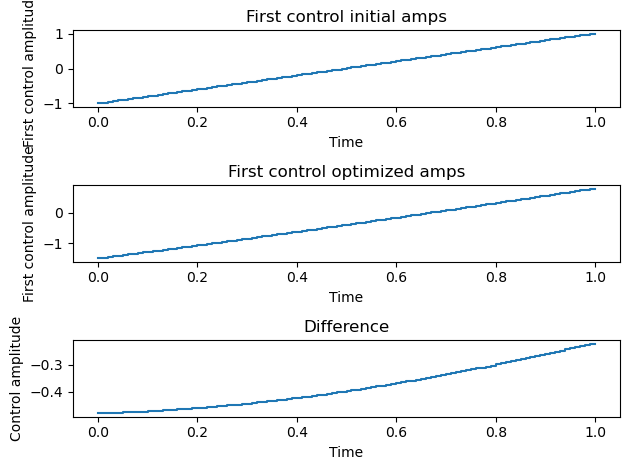

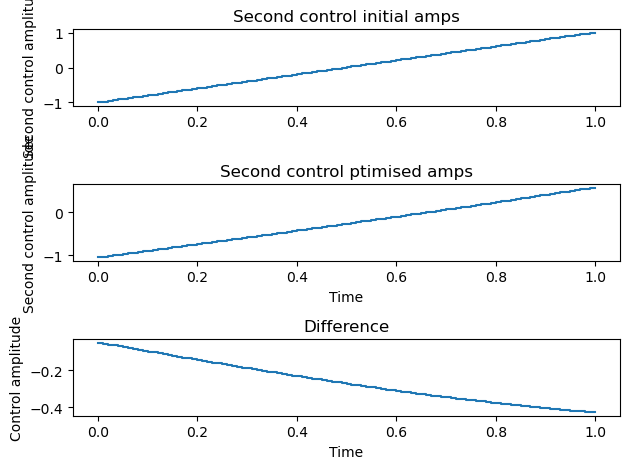

In [15]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(3, 1, 1)
ax1.set_title("First control initial amps")
ax1.set_xlabel("Time")
ax1.set_ylabel("First control amplitude")
ax1.step(result.time, 
         np.hstack((result.initial_amps[:, 0], result.initial_amps[-1, 0])), 
         where='post')

ax2 = fig1.add_subplot(3, 1, 2)
ax2.set_title("First control optimized amps")
ax2.set_xlabel("Time")
ax2.set_ylabel("First control amplitude")
ax2.step(result.time, 
         np.hstack((result.final_amps[:, 0], result.final_amps[-1, 0])), 
         where='post')

ax3 = fig1.add_subplot(3, 1, 3)
ax3.set_title("Difference")
ax3.set_xlabel("Time")
ax3.set_ylabel("Control amplitude")
ax3.step(result.time, 
         np.hstack((result.final_amps[:, 0], result.final_amps[-1, 0])) - np.hstack((result.initial_amps[:, 0], result.initial_amps[-1, 0])), 
         where='post')
plt.tight_layout()


fig2 = plt.figure()
ax4 = fig2.add_subplot(3, 1, 1)
ax4.set_title("Second control initial amps")
ax4.set_ylabel("Second control amplitude")
ax4.step(result.time, 
         np.hstack((result.initial_amps[:, 1], result.initial_amps[-1, 1])), 
         where='post')

ax5 = fig2.add_subplot(3, 1, 2)
ax5.set_title("Second control ptimised amps")
ax5.set_xlabel("Time")
ax5.set_ylabel("Second control amplitude")
ax5.step(result.time, 
         np.hstack((result.final_amps[:, 1], result.final_amps[-1, 1])), 
         where='post')

ax6 = fig2.add_subplot(3, 1, 3)
ax6.set_title("Difference")
ax6.set_xlabel("Time")
ax6.set_ylabel("Control amplitude")
ax6.step(result.time, 
         np.hstack((result.final_amps[:, 1], result.final_amps[-1, 1])) - np.hstack((result.initial_amps[:, 1], result.initial_amps[-1, 1])), 
         where='post')
plt.tight_layout()

plt.show()

## Now use the optimized pulse (time-dependent Hamiltonian) to simulate time evolution
For this case, consider QobjEvo with "Array dependence"

## Simulate evolution with in larger truncation Fock space (testing state preparation)
specify: 
- optimized_N
- alpha

In [16]:
from qutip import Options

# H_c amplitudes (from pulse optimization)
amplitudes_c = result.final_amps[:, 0]
amplitudes_T = result.final_amps[:, 1]
# amplitudes_c = result.initial_amps[:, 0]
# amplitudes_T = result.initial_amps[:, 1]

tlist = np.linspace(0, evo_time, n_ts)
H_array_form = qt.QobjEvo([H_d, [H_c[0], amplitudes_c], [H_c[1], amplitudes_T]], tlist=tlist)

# res = qt.mesolve(H_array_form, psi_0, tlist)
res = qt.sesolve(H_array_form, psi_0, tlist, options=Options(nsteps=5000))

# tau = evo_time / n_ts
# for i in range(0, evo_time, tau):
#     psi_0.value() * np.exp(-1j * H_d.full() * tau) * np.exp(-1j * H_c[0].full() * tau) * np.exp(-1j * H_c[1].full() * tau)
#     print(qt.fidelity())

# Now use mesolve() to solve for time evolution using the optimised pulse
# res = qt.mesolve(H_array_form, psi_0, tlist, [], [])

#### check fidelity ####
# see fidelity at the end
qt.metrics.fidelity(res.states[-1].unit(), psi_targ.unit())
# see fidelity at each time step
# for i in range(0, n_ts):
#     print(i, qt.metrics.fidelity(res.states[i].unit(), psi_targ.unit()))

0.99998235969216

# Self-implemented simulation

sesolve final fidelity:  0.99998235969216
self-implemented final fidelity:  0.9999649071138246


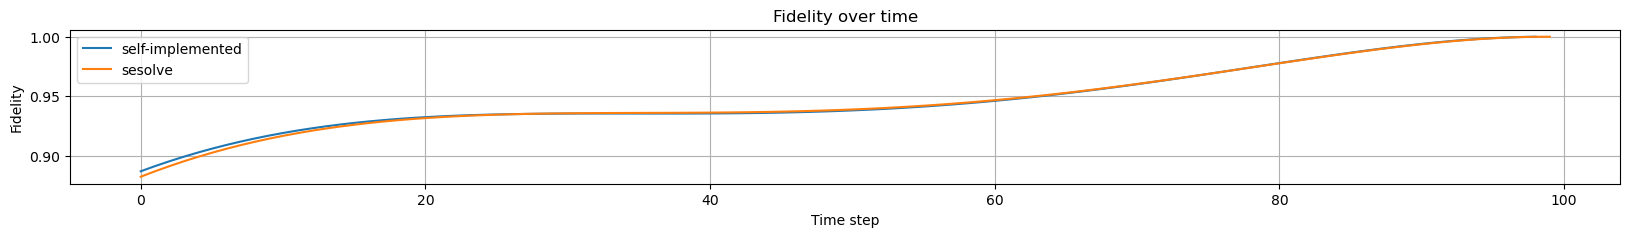

In [17]:
# H_c amplitudes (from pulse optimization)
amplitudes_0 = result.final_amps[:, 0]
amplitudes_1 = result.final_amps[:, 1]


tlist = np.linspace(0, evo_time, n_ts)
H_array_form = qt.QobjEvo([H_d, [H_c[0], amplitudes_c], [H_c[1], amplitudes_T]], tlist=tlist)

# res = qt.mesolve(H_array_form, psi_0, tlist)
res = sesolve(H_array_form, psi_0, tlist,options=Options(nsteps=5000))


fidelities1 = []
for i in range(0, n_ts):
    fidelities1.append(qutip.metrics.fidelity(res.states[i].unit(), psi_targ.unit()))

print("sesolve final fidelity: ", fidelities1[-1])


### self-implemented forward propagation ###
from scipy.linalg import expm

psi_init = psi_0.full()
psi_end = psi_targ.full()
fidelities = []
for n in range(len(tlist) - 1):
    H = H_d + sum([H_c[i] * result.final_amps[n, i] for i in range(n_ctrls)])
    H = H.full()
    dt = tlist[n + 1] - tlist[n]
    o = expm(-1j * H * dt)
    psi_init = np.matmul(o,psi_init)
    fid = np.abs(np.matmul(np.transpose(np.conjugate(psi_init)),psi_end))
    # 
    fidelities.append(fid[0])
# print(shape(psi_init))

print("self-implemented final fidelity: ", fidelities[-1][0])


### plotting ###
# Create a new figure
plt.figure(figsize=(20, 2))

# Plot fidelities
plt.plot(fidelities, label='self-implemented')
plt.plot(fidelities1, label='sesolve')

# Set the title and labels for the plot
plt.title('Fidelity over time')
plt.xlabel('Time step')
plt.ylabel('Fidelity')

# Add a legend
plt.legend()

plt.grid(True)
# Show the plot
plt.show()

## simulate with higher N

Text(0.5, 1.0, 'optimized with N = 5, forward propogation with different N values')

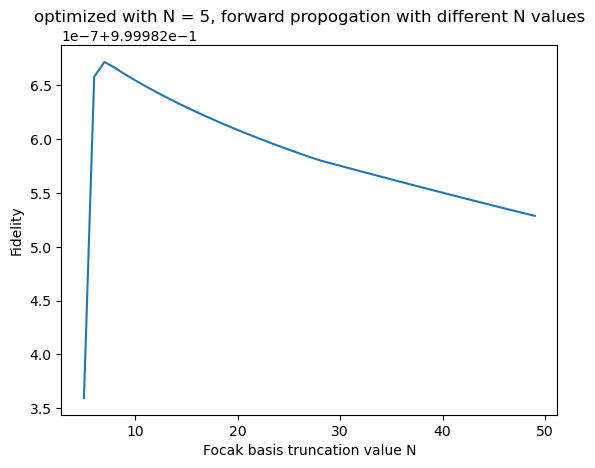

In [18]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
# increase truncation N here
optimized_N = 5
# alpha = 1.4142135623730951
alpha = 0.5
# f = 'ctrl_amps_final_coherent_to_cat_state_n_ts50_evo_time100_ptypeZERO_alpha0.5_N10_fid_err_targ0.0001_max_iter100000_max_wall_time10000.txt'
# # f = f'ctrl_amps_final_coherent_to_cat_state_n_ts3000_ptypeZERO_alpha{alpha}_N{optimized_N}_fid_err_targ0.0001_max_iter100000_max_wall_time10000.txt'
# data = np.genfromtxt(f, delimiter='\t') 

# H_c amplitudes (from optimized pulse)
amplitudes_c = result.final_amps[:, 0]
amplitudes_T = result.final_amps[:, 1]

# reset n_ts to a higher value
tlist = np.linspace(0, evo_time, n_ts)

fidelity_list = []
N_upper_bound = 50
for i in range(optimized_N, N_upper_bound):
    ##### use higher N truncation value for states and operators ######
    # set chi to 0, don't need this for testing state-to-state transfer
    N = i
    H_dt = tensor(qt.num(N), identity(2)) + tensor(identity(N), sigmaz())
    H_c4 = [tensor(qt.destroy(N) + qt.create(N), identity(2)),
        tensor(1j*(qt.destroy(N) - qt.create(N)), identity(2))]
    #### set Hamiltonian ####
    H_d = H_dt
    H_c = H_c4

    #### initial and target states ####
    cavity_init_state = qt.coherent(N, alpha)
    cavity_target_state = (qt.coherent(N, alpha) + qt.coherent(N, -alpha)).unit()
    cavity_init_state_testing = qt.coherent(N, 0)
    cavity_target_state_testing = qt.coherent(N, alpha)
    qubit_state = Qobj([[1], [0]])
    psi_0 = tensor(cavity_init_state_testing, qubit_state)
    psi_targ = tensor(cavity_target_state_testing, qubit_state)

    #### Simulate ####
    H_array_form = qt.QobjEvo([H_d, [H_c[0], amplitudes_c], [H_c[1], amplitudes_T]], tlist=tlist)
    res = qt.sesolve(H_array_form, psi_0, tlist)

    final_fidelity = qt.metrics.fidelity(res.states[-1].unit(), psi_targ.unit())
    fidelity_list.append(final_fidelity)

plt.plot(range(optimized_N, 50), fidelity_list)
plt.xlabel('Focak basis truncation value N')   
plt.ylabel('Fidelity')
plt.title(f'optimized with N = {optimized_N}, forward propogation with different N values')
# plt.legend()

# see fidelity at each time step
# for i in range(0, n_ts):
#     print(i, qt.metrics.fidelity(res.states[i].unit(), psi_targ.unit()))
